<a href="https://colab.research.google.com/github/nilthonch76/Eurosat2022/blob/main/EUROSAT2022_v2_Nilton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import optimizers, backend
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
import imutils
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET = "/content/drive/MyDrive/Colab Notebooks/EuroSAT/2750"
LABELS = os.listdir(DATASET)

print(LABELS)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


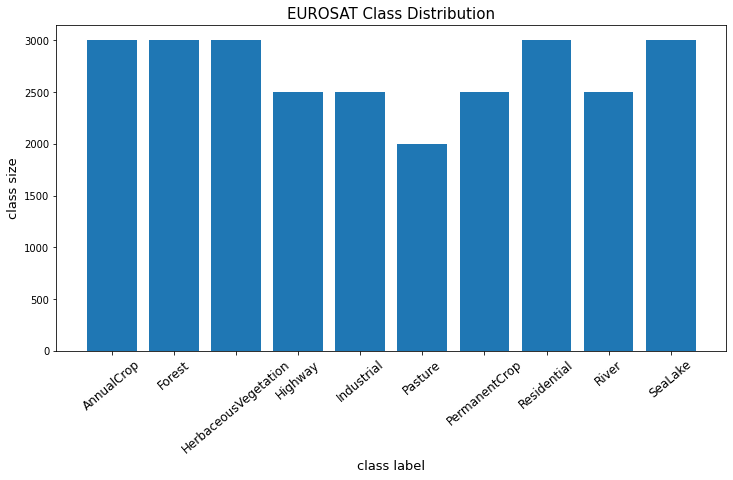

In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))
    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

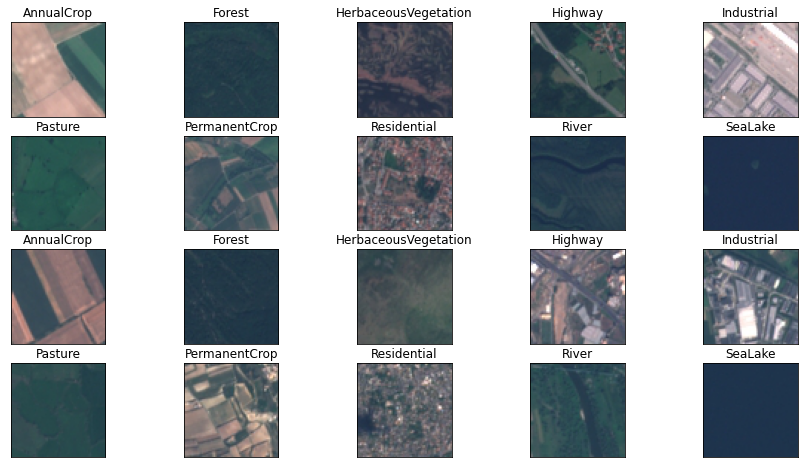

In [ ]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS] 

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths): #
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [ ]:
# ACCEDER A LAS CARPETAS DE ENTRENAMIENTO Y VALIDACION
import re # se accede a las carpetas de entenamiento y validacion
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/EuroSAT/working/training'# CARPETA DE ENTRENAMIENTO 21600
TEST_DIR = '/content/drive/MyDrive/Colab Notebooks/EuroSAT//working/testing' # cAERPETA DE VALIDACION O TESTING
BATCH_SIZE = 64  #
ANCHO = 64
ALTO = 64 
CANALES = 3
NUM_CLASSES = len(LABELS) # LONGITUD DE LAS CLASES
INPUT_SHAPE = (ALTO, ANCHO, CANALES) # 
CLASS_MODE = 'categorical'

In [ ]:
#DATA AUGMENTATION
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=60,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #vertical_flip = True
#   validation_split=0.2
)

# SE LE DIRECCIONA A LA CARPETA TRAIN
train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE, # SE TOMARAN DE 64 PARA AJUSTAR LOS PESOS
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True, # Se toma de manera aleatoria
    seed=69 # semilla para valores aleatorios para resultados 
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
TRAIN_SIZE = 21600 # IMAGENES E LA CARPETA DE ENTRENAMIENTO
TEST_SIZE = 5400 # IMAGENES EN LA CARPETA DE TEST O VALIDACION

In [ ]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
# Creamos un diccionario de numero de clase a palabra
clase2nombre = dict((indice, palabra) for (palabra, indice) in train_generator.class_indices.items())

In [ ]:
clase2nombre[5]

'Pasture'

In [ ]:
#np.save('class_indices', train_generator.class_indices)

## 1. Modelo propio

In [ ]:
# Escribe la línea de código que elimina información previa de los modelos 
backend.clear_session()

In [ ]:
# EJERCICIO modelos ligero
# Define tu modelo
modeloConv = Sequential()
modeloConv.add(Conv2D(16, kernel_size=(2,2), activation = 'relu', 
                      input_shape = (64,64,3)))
modeloConv.add(MaxPool2D(pool_size = (2,2)))
modeloConv.add(Conv2D(32, kernel_size=(2,2), activation = 'relu'))
modeloConv.add(MaxPool2D(pool_size = (2,2)))
modeloConv.add(Conv2D(64, kernel_size=(2,2), activation = 'relu'))
modeloConv.add(MaxPool2D(pool_size = (2,2)))
modeloConv.add(Flatten())
#modeloConv.add(Dropout(0.3))
modeloConv.add(Dense(40, activation='relu'))
#modeloConv.add(Dropout(0.3))
modeloConv.add(Dense(10, activation='softmax'))
# EJERCICIO
# Muestra la tabla con las características de tu modelo
modeloConv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0

In [ ]:
# Define del optimizador Adam
adam = optimizers.Adam(learning_rate = 0.001)

# Compila el modelo
modeloConv.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

# Define un checkpointer para guardar los pesos sinapticos de la red
checkpointer = ModelCheckpoint('modelo_v1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
M = modeloConv.fit(
        train_generator, # DIRECCION DE LA CARPETA DE ENTRENAMIENTO
        steps_per_epoch = 10,#round(TRAIN_SIZE/BATCH_SIZE),
        epochs = 10,
        validation_data = test_generator,
        validation_steps = 10,#round(TEST_SIZE/BATCH_SIZE), 
        callbacks = [checkpointer],
        verbose = True)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.2855 - accuracy: 0.0797 
Epoch 1: val_accuracy improved from -inf to 0.00469, saving model to modelo_v1.h5
10/10 [==============================] - 336s 35s/step - loss: 2.2855 - accuracy: 0.0797 - val_loss: 2.0504 - val_accuracy: 0.0047
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 2.1760 - accuracy: 0.1031 
Epoch 2: val_accuracy improved from 0.00469 to 0.03906, saving model to modelo_v1.h5
10/10 [==============================] - 149s 15s/step - loss: 2.1760 - accuracy: 0.1031 - val_loss: 2.0028 - val_accuracy: 0.0391
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 2.1014 - accuracy: 0.2141 
Epoch 3: val_accuracy improved from 0.03906 to 0.74219, saving model to modelo_v1.h5
10/10 [==============================] - 142s 14s/step - loss: 2.1014 - accuracy: 0.2141 - val_loss: 1.7319 - val_accuracy: 0.7422
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 2.

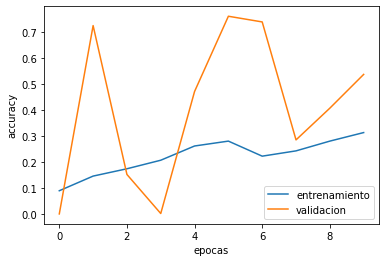

In [ ]:
plt.plot(M.history['accuracy'], label='entrenamiento')
plt.plot(M.history['val_accuracy'], label='validacion')
plt.legend(loc='lower right')
plt.xlabel('epocas')
plt.ylabel('accuracy')
plt.show()

## 2. Transferencia de aprendizaje

In [ ]:
backend.clear_session()

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
#DATA AUGMENTATION
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    preprocess_input,
    #rotation_range=60,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #vertical_flip = True
#   validation_split=0.2
)

# SE LE DIRECCIONA A LA CARPETA TRAIN
train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE, # SE TOMARAN DE 64 PARA AJUSTAR LOS PESOS
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True, # Se toma de manera aleatoria
    seed=69 # semilla para valores aleatorios para resultados 
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    preprocess_input,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
#modelo basado en VGG16
modeloVGG16_base = VGG16(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
#indicacion para no entrenar las convolucionales en el modelo
for layer in modeloVGG16_base.layers:
  layer.trainable = False

In [ ]:
#Definir las ultimas capas
modeloVGG16_intermedio = modeloVGG16_base.output
modeloVGG16_intermedio = Flatten()(modeloVGG16_intermedio)
modeloVGG16_intermedio = Dropout(0.2)(modeloVGG16_intermedio)
modeloVGG16_intermedio = Dense(150, activation='relu', use_bias=True)(modeloVGG16_intermedio)
modeloVGG16_intermedio = Dropout(0.2)(modeloVGG16_intermedio)
modeloVGG16_intermedio = Dense(80, activation='relu', use_bias=True)(modeloVGG16_intermedio)
modeloVGG16_intermedio = Dropout(0.2)(modeloVGG16_intermedio)
modeloVGG16_intermedio = Dense(10, activation='softmax', use_bias=True)(modeloVGG16_intermedio)

modeloVGG16 = Model(inputs = modeloVGG16_base.input, outputs = modeloVGG16_intermedio)
modeloVGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
# Define del optimizador Adam
adam = optimizers.Adam(learning_rate = 0.001)

# Compila el modelo
modeloVGG16.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

# Define un checkpointer para guardar los pesos sinapticos de la red
checkpointer = ModelCheckpoint('modeloVGG16_v1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
M = modeloVGG16.fit(
        train_generator,
        steps_per_epoch = 10,#round(TRAIN_SIZE/BATCH_SIZE),
        epochs = 10,
        validation_data = test_generator,
        validation_steps = 10,#round(TEST_SIZE/BATCH_SIZE), 
        callbacks = [checkpointer],
        verbose = True)

Epoch 1/10
10/10 [==============================] - 369s 36s/step - loss: 2.2176 - accuracy: 0.2078 - val_loss: 1.4043 - val_accuracy: 0.8141

Epoch 00001: val_accuracy improved from -inf to 0.81406, saving model to modeloVGG16_v1.h5
Epoch 2/10
10/10 [==============================] - 159s 16s/step - loss: 1.7759 - accuracy: 0.3828 - val_loss: 1.0057 - val_accuracy: 0.8047

Epoch 00002: val_accuracy did not improve from 0.81406
Epoch 3/10
10/10 [==============================] - 153s 15s/step - loss: 1.4724 - accuracy: 0.4703 - val_loss: 0.9169 - val_accuracy: 0.7422

Epoch 00003: val_accuracy did not improve from 0.81406
Epoch 4/10
10/10 [==============================] - 154s 15s/step - loss: 1.3191 - accuracy: 0.5141 - val_loss: 0.7173 - val_accuracy: 0.7875

Epoch 00004: val_accuracy did not improve from 0.81406
Epoch 5/10
10/10 [==============================] - 147s 15s/step - loss: 1.1729 - accuracy: 0.5703 - val_loss: 0.6422 - val_accuracy: 0.8047

Epoch 00005: val_accuracy did

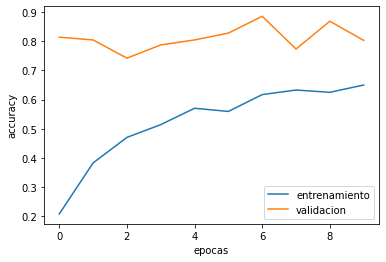

In [ ]:
plt.plot(M.history['accuracy'], label='entrenamiento')
plt.plot(M.history['val_accuracy'], label='validacion')
plt.legend(loc='lower right')
plt.xlabel('epocas')
plt.ylabel('accuracy')
plt.show()

## 3. Prueba sobre el modelo

In [ ]:
#modeloConv.load_weights('modelo_v1.h5')
modeloVGG16.load_weights('/content/drive/MyDrive/Colab Notebooks/EuroSAT/modeloVGG16_v1.h5')

/content/drive/MyDrive/Colab Notebooks/EuroSAT//working/testing/Pasture/Pasture_1984.jpg


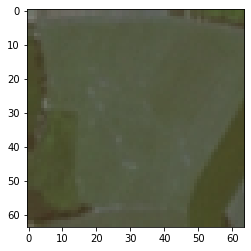

In [ ]:
clase = 'Pasture'
img_test_path = os.path.join(TEST_DIR, clase, clase + '_1984.jpg')
print(img_test_path)
img_test = cv2.imread(img_test_path)
plt.imshow(img_test, cmap = 'Accent')
plt.show()

In [ ]:
#class_modeloConv = modeloConv.predict_classes(img_test.reshape(1, ALTO, ANCHO, CANALES))
class_modeloVGG16 = modeloVGG16.predict(img_test.reshape(1, ALTO, ANCHO, CANALES))
#print('Prediccion con modelo propio: ', class_modeloConv)
print('Prediccion con modelo preentrenado: ', np.argmax(class_modeloVGG16))

Prediccion con modelo preentrenado:  8



## Detección en imágenes grandes

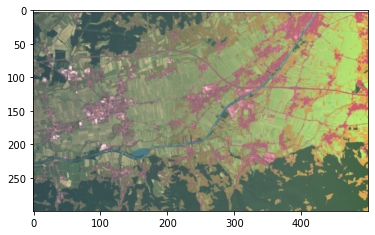

In [ ]:
img_test = cv2.imread('/content/drive/MyDrive/Colab Notebooks/EuroSAT/imgCovering_3.png')
img_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2BGR) 
# img_test = img_test[200:600, 0:400, :]
plt.imshow(img_test, cmap = 'Accent')
plt.show()

In [ ]:
IMG_ALTO = img_test.shape[0]
IMG_ANCHO = img_test.shape[1]

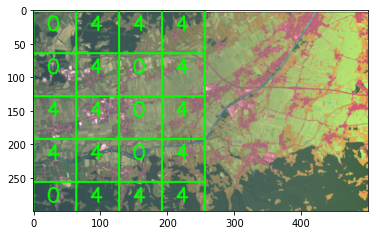

In [ ]:
x = 0
y = 0
umbral_probabilidad = 0.6
for i in range(0,IMG_ALTO - ALTO, ALTO):
  x += 1
  for j in range(0,IMG_ANCHO - ANCHO, ANCHO):
    y +=1
    window = img_test[i:i+ALTO, j:j+ANCHO, :]
    clases_window = modeloVGG16.predict(window.reshape(1, ALTO, ANCHO, CANALES))
    # Dibujando un rectangulo
    if np.amax(clases_window) > umbral_probabilidad:
      # Dibujamos el bounding box en la imagen original
      cv2.rectangle(img_test, (i, j), (i + 64, j + 64),
                    (0,255,0), 2)
      # Escribimos un texto con la clase del objeto
      #etiqueta = clase2nombre[np.argmax(clases_window)]
      etiqueta = str(np.argmax(clases_window))
      cv2.putText(img_test, etiqueta, (i + 20, j + 30), 
                  cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,0), 2)

plt.imshow(img_test, cmap='Accent')
plt.show()